In [3]:

import pandas as pd
from genre_predictor import GenrePredictor


In [2]:
"""
Example of training a new GenrePredictor and saving it.
"""
print("=== Training a new GenrePredictor ===")

# Create a new GenrePredictor
predictor = GenrePredictor(random_state=42, models_dir='saved_models')

# Load and prepare data
predictor.load_data(
    file_path='wiki_movie_plots_deduped_cleaned.csv',
    plot_col='plot_lemmatized',
    genre_col='genre_list',
    location_col='Origin/Ethnicity'
)

=== Training a new GenrePredictor ===
Loaded dataset with 34886 movies
After filtering empty genres: 26808 movies


In [3]:
# Prepare features
predictor.prepare_features()


TF-IDF features shape: (26808, 300)
Target shape: (26808, 20)
Genre classes: ['action' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'history' 'horror' 'musical'
 'mystery' 'romance' 'sci-fi' 'sport' 'thriller' 'war' 'western']
Location features shape: (26808, 24)
Combined features shape: (26808, 324)
Selected features shape: (26808, 100)


In [4]:
# Train models (using only basic and intermediate for speed)
predictor.train_models(model_levels=['basic'])
    

Ading basic models...
Evaluating Logistic Regression...
Evaluating Multinomial Naive Bayes...
Evaluating Decision Tree...
Evaluation complete. Best model: Decision Tree (F1-micro: 0.3028)
Model Performance Summary:
                     Model  F1-micro  F1-macro  F1-weighted  Hamming Loss
0            Decision Tree  0.302825  0.182258     0.302741      0.082395
1      Logistic Regression  0.250835  0.123547     0.238614      0.056481
2  Multinomial Naive Bayes  0.088626  0.026326     0.079432      0.058877


In [5]:
# Save models and preprocessing components
save_info = predictor.save_models(
    dataset_name='movie_genre_predictor',
    save_all=True,
    include_data=False
)

print(f"Models and preprocessing components saved to {save_info['base_directory']}")


Preprocessing components saved to saved_models\movie_genre_predictor_preprocessing_20250521_015606
Model Performance Summary:
                     Model  F1-micro  F1-macro  F1-weighted  Hamming Loss
0            Decision Tree  0.302825  0.182258     0.302741      0.082395
1      Logistic Regression  0.250835  0.123547     0.238614      0.056481
2  Multinomial Naive Bayes  0.088626  0.026326     0.079432      0.058877
All models saved successfully to saved_models\movie_genre_predictor_20250521_015606
Models and preprocessing components saved to saved_models\movie_genre_predictor_20250521_015606


# Loading and Predict


In [4]:
print("\n=== Loading a saved GenrePredictor ===")

# Load the saved predictor
predictor = GenrePredictor.load(models_dir='saved_models')

print(f"Loaded predictor with best model: {predictor.evaluator.best_model_name}")



=== Loading a saved GenrePredictor ===
Preprocessing components loaded from saved_models\movie_genre_predictor_preprocessing_20250521_015606
Successfully loaded models from saved_models\movie_genre_predictor_20250521_015606
Loaded predictor with best model: Decision Tree


In [5]:
# Create some example movie data
example_movies = [
    {
        'plot_lemmatized': "A superhero with extraordinary powers fights against an evil villain to save the world from destruction.",
        'Origin/Ethnicity': "American"
    },
    {
        'plot_lemmatized': "Two people meet and fall in love despite their different backgrounds and families who disapprove of their relationship.",
        'Origin/Ethnicity': "British"
    },
    {
        'plot_lemmatized': "A detective investigates a series of mysterious murders in a small town, uncovering dark secrets about the residents.",
        'Origin/Ethnicity': "French"
    },
    {
        'plot_lemmatized': "Astronauts travel to a distant planet where they discover an alien civilization and must find a way to communicate with them.",
        'Origin/Ethnicity': "American"
    }
]

In [6]:
# Convert to DataFrame
example_df = pd.DataFrame(example_movies)
example_df

,plot_lemmatized,Origin/Ethnicity
0,A superhero with extraordinary powers fights a...,American
1,Two people meet and fall in love despite their...,British
2,A detective investigates a series of mysteriou...,French
3,Astronauts travel to a distant planet where th...,American


In [7]:

# Make predictions
print("\nMaking predictions on example movies:")
predictions = predictor.predict(example_df)



Making predictions on example movies:


In [8]:
predictions

[['fantasy', 'romance'], ['drama', 'romance'], ['comedy', 'drama'], ['action']]

In [11]:
# Display results
for i, (movie, genres) in enumerate(zip(example_movies, predictions)):
    print(f"\nMovie {i+1}:")
    print(f"Plot: {movie['plot_lemmatized'][:100]}...")
    print(f"Origin: {movie['Origin/Ethnicity']}")
    print(f"Predicted genres: {genres}")



Movie 1:
Plot: A superhero with extraordinary powers fights against an evil villain to save the world from destruct...
Origin: American
Predicted genres: ['fantasy', 'romance']

Movie 2:
Plot: Two people meet and fall in love despite their different backgrounds and families who disapprove of ...
Origin: British
Predicted genres: ['drama', 'romance']

Movie 3:
Plot: A detective investigates a series of mysterious murders in a small town, uncovering dark secrets abo...
Origin: French
Predicted genres: ['comedy', 'drama']

Movie 4:
Plot: Astronauts travel to a distant planet where they discover an alien civilization and must find a way ...
Origin: American
Predicted genres: ['action']


In [12]:
print(predictor.df)

None


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()
df = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')

In [14]:

y = mlb.fit_transform(df['genre_list'])

In [16]:
y.shape

(34886, 27)

In [17]:
mlb.classes_

array([' ', "'", ',', '-', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w',
       'y'], dtype=object)

In [18]:
df['genre_list']

0                []
1                []
2                []
3                []
4                []
            ...    
34881            []
34882    ['comedy']
34883    ['comedy']
34884    ['comedy']
34885            []
Name: genre_list, Length: 34886, dtype: object

In [2]:
"""
Create a scikit-learn pipeline for preprocessing new data.

This pipeline will transform raw text and location data into the same
feature space used for training.
"""


from scipy.sparse import hstack, csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline


class LocationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, location_categories):
        self.location_categories = location_categories

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_loc = pd.get_dummies(X, prefix='loc')

        # Ensure all expected categories are present
        for cat in self.location_categories:
            if cat not in X_loc.columns:
                X_loc[cat] = 0

        # Ensure only the expected categories are used, in the same order
        X_loc = X_loc[self.location_categories]

        # 🛠 Convert to float32 or float64 before passing to csr_matrix
        return csr_matrix(X_loc.values.astype('float32'))
tfidf = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 2),
            strip_accents='unicode',
            sublinear_tf=True
        )

mlb = MultiLabelBinarizer()
selector = SelectKBest(chi2, k=100)

# Use ColumnTransformer to apply transformers to specific columns
preprocessor = ColumnTransformer([
    ('plot_tfidf', tfidf, 'plot'),
    ('location', LocationTransformer([1,2,3,4]), 'origin')
])

# Final pipeline
pipeline = Pipeline([
    ('features', preprocessor),
    ('selector', selector)
])
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('plot_tfidf',
                                                  TfidfVectorizer(max_features=300,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english',
                                                                  strip_accents='unicode',
                                                                  sublinear_tf=True),
                                                  'plot'),
                                                 ('location',
                                                  LocationTransformer(location_categories=[1,
                                                                                           2,
                                                                                           3,
                                                                                           4]),
                                                  'origin')])),
                ('selector',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x0000015777424B80>))])

In [11]:
# Compare predictions from different genre prediction models on a large test sample


In [12]:
df = pd.read_csv('wiki_movie_plots_deduped_cleaned.csv')

predictor = GenrePredictor.load(models_dir='saved_models')
predictor.predict(df.head(10))

Preprocessing components loaded from saved_models\movie_genre_predictor_preprocessing_20250521_015606
Successfully loaded models from saved_models\movie_genre_predictor_20250521_015606


[['comedy'],
 ['comedy'],
 ['comedy'],
 ['comedy', 'sci-fi'],
 [],
 ['comedy'],
 ['western'],
 ['comedy'],
 [],
 []]

In [13]:
predictor.evaluator.models

{'Logistic Regression': OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                  random_state=42)),
 'Multinomial Naive Bayes': OneVsRestClassifier(estimator=MultinomialNB()),
 'Decision Tree': OneVsRestClassifier(estimator=DecisionTreeClassifier(random_state=42))}

Adding basic models...
Adding intermediate models...
Adding advanced models...
Evaluating models...
Evaluating Logistic Regression...
Evaluating Multinomial Naive Bayes...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Linear SVM...
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 233, number of negative: 567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291250 -> initscore=-0.889321
[LightGBM] [Info] Start training from score -0.889321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

c:\Users\161070\OneDrive - Arrow Electronics, Inc\MyWork\Tools\Projects\OneTimeProjects\ML project\ml_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\161070\OneDrive - Arrow Electronics, Inc\MyWork\Tools\Projects\OneTimeProjects\ML project\ml_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\161070\OneDrive - Arrow Electronics, Inc\MyWork\Tools\Projects\OneTimeProjects\ML project\ml_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\161070\OneDrive - Arrow Electronics, Inc\MyWork\Tools\Projects\OneTimeProjects\ML project\ml_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does 

Evaluation complete. Best model: Gradient Boosting (F1-micro: 0.7550)
Model Performance Summary:
                     Model  F1-micro  F1-macro  F1-weighted  Hamming Loss
0        Gradient Boosting  0.754986  0.729298     0.752713         0.172
1                  XGBoost  0.754610  0.728410     0.752528         0.173
2                 LightGBM  0.746398  0.723502     0.743633         0.176
3               Linear SVM  0.743262  0.717881     0.740477         0.181
4      Logistic Regression  0.742616  0.714029     0.740762         0.183
5            Random Forest  0.730887  0.675425     0.719593         0.176
6  Multinomial Naive Bayes  0.722925  0.704521     0.723564         0.197
7       Neural Network MLP  0.683658  0.567399     0.651897         0.211
8            Decision Tree  0.634794  0.605982     0.633691         0.275
Generating visualizations...


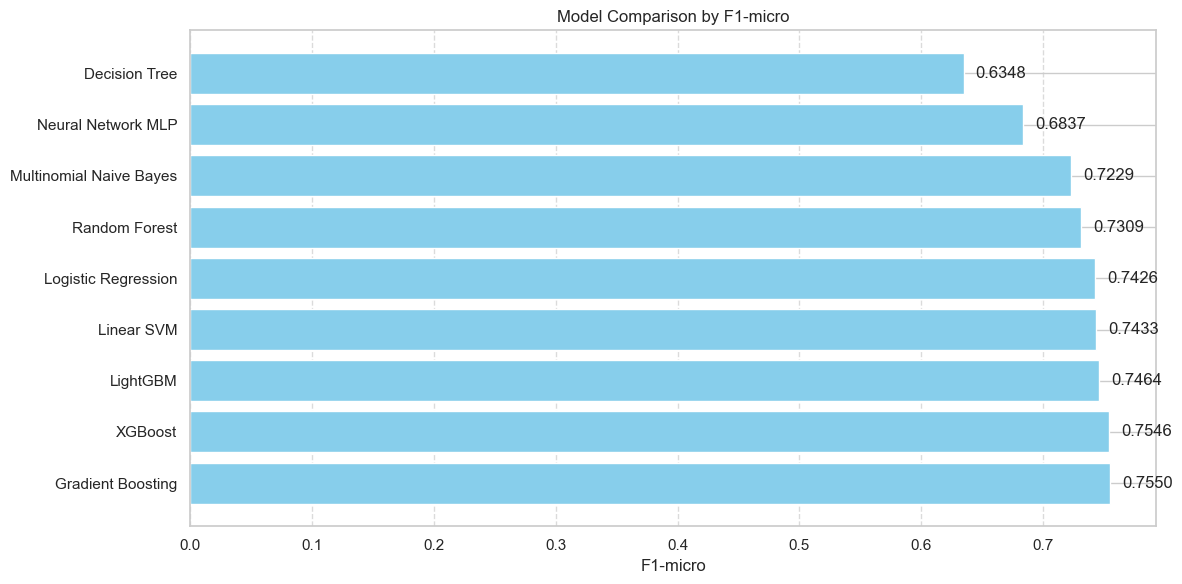

In [16]:
from model_evaluator import ModelEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_compare_models(X, y, test_size=0.2, feature_names=None, target_names=None):
    """
    Evaluate all available models and show their comparison.
    
    Parameters:
    -----------
    X : array-like
        Features for model training and evaluation
    y : array-like
        Target labels
    test_size : float, default=0.2
        Proportion of data to use for testing
    feature_names : list, default=None
        Names of the features
    target_names : list, default=None
        Names of the target classes
    
    Returns:
    --------
    evaluator : ModelEvaluator
        The evaluator with all models trained and evaluated
    """
    # Create an evaluator
    evaluator = ModelEvaluator()
    
    # Add all available models
    print("Adding basic models...")
    evaluator.add_basic_models()
    
    print("Adding intermediate models...")
    evaluator.add_intermediate_models()
    
    print("Adding advanced models...")
    evaluator.add_advanced_models()
    
    # Evaluate all models
    print("Evaluating models...")
    evaluator.evaluate_models(
        X=X, 
        y=y, 
        test_size=test_size,
        feature_names=feature_names,
        target_names=target_names
    )
    
    # Print summary
    summary_df = evaluator.print_summary()
    
    # Visualize model comparison
    print("Generating visualizations...")
    evaluator.plot_model_comparison()
    
    # Create additional visualizations
    
    
    return evaluator,summary_df

# Example usage
if __name__ == "__main__":
    # This is a placeholder for actual data loading
    # Replace with your actual data loading code
    from sklearn.datasets import make_multilabel_classification
    from sklearn.preprocessing import MultiLabelBinarizer
    
    # Generate sample data for demonstration
    X, y = make_multilabel_classification(
        n_samples=1000, 
        n_features=20, 
        n_classes=5, 
        n_labels=2,
        random_state=42
    )
    
    # Create feature and target names for demonstration
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    target_names = [f"class_{i}" for i in range(y.shape[1])]
    
    # Evaluate and compare all models
    evaluator,summary_df = evaluate_and_compare_models(
        X, 
        y, 
        test_size=0.2,
        feature_names=feature_names,
        target_names=target_names
    )
    """
    Create detailed comparison visualizations for model performance.
    
    Parameters:
    -----------
    summary_df : DataFrame
        DataFrame containing model performance metrics
    """
    

In [18]:
summary_df

,Model,F1-micro,F1-macro,F1-weighted,Hamming Loss
0,Gradient Boosting,0.754986,0.729298,0.752713,0.172
1,XGBoost,0.754610,0.728410,0.752528,0.173
2,LightGBM,0.746398,0.723502,0.743633,0.176
3,Linear SVM,0.743262,0.717881,0.740477,0.181
4,Logistic Regression,0.742616,0.714029,0.740762,0.183
5,Random Forest,0.730887,0.675425,0.719593,0.176
6,Multinomial Naive Bayes,0.722925,0.704521,0.723564,0.197
7,Neural Network MLP,0.683658,0.567399,0.651897,0.211
8,Decision Tree,0.634794,0.605982,0.633691,0.275


In [19]:
# Set style
sns.set(style="whitegrid")

# Plot F1 scores comparison
plt.figure(figsize=(12, 8))

# Create a melted dataframe for easier plotting
metrics_to_plot = ['F1-micro', 'F1-macro', 'F1-weighted']
melted_df = pd.melt(
    summary_df, 
    id_vars=['Model'], 
    value_vars=metrics_to_plot,
    var_name='Metric', 
    value_name='Score'
)

<Figure size 1200x800 with 0 Axes>

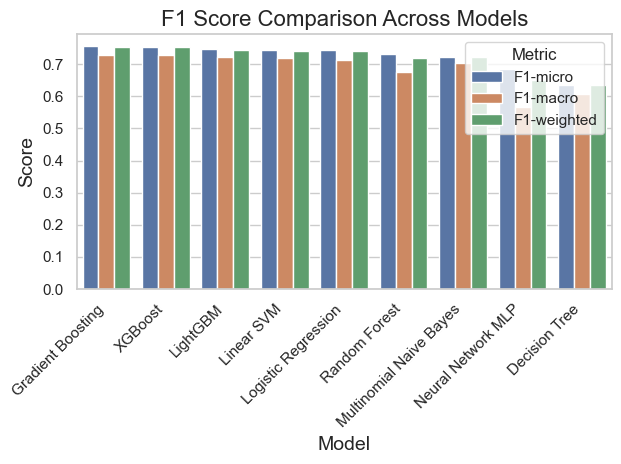

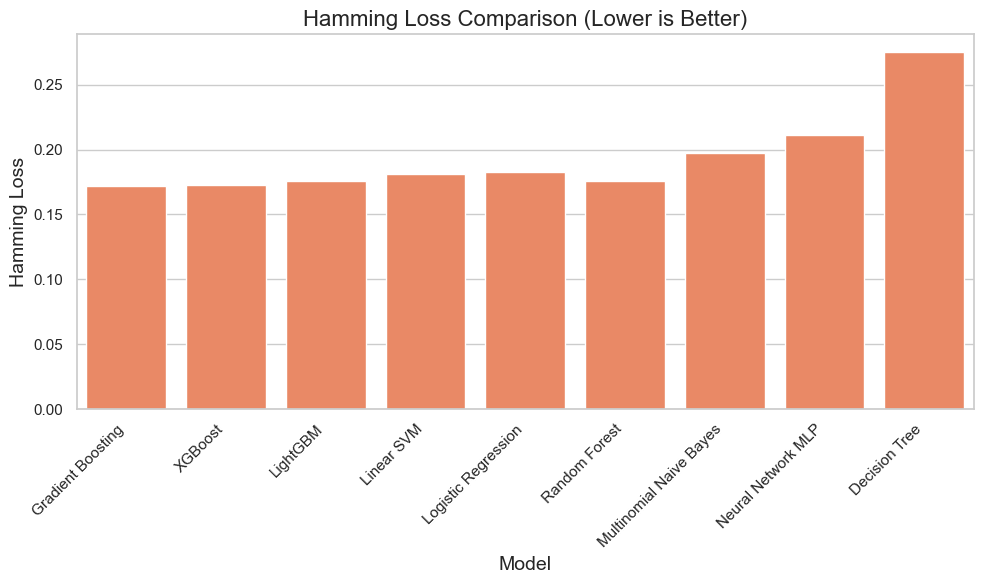

NameError: name 'save_info' is not defined

In [ ]:


# Create the grouped bar chart
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df)
plt.title('F1 Score Comparison Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('model_f1_comparison.png')
plt.show()

# Plot Hamming Loss (lower is better)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Hamming Loss', data=summary_df, color='coral')
plt.title('Hamming Loss Comparison (Lower is Better)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Hamming Loss', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_hamming_loss_comparison.png')
plt.show()



Analyzing feature importance for Logistic Regression...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for Multinomial Naive Bayes...
  ✓ Permutation importance calculated
Analyzing feature importance for Decision Tree...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for Random Forest...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for Linear SVM...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for Gradient Boosting...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for XGBoost...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing feature importance for LightGBM...
  ✓ Direct feature importance extracted
  ✓ Permutation importance calculated
Analyzing 

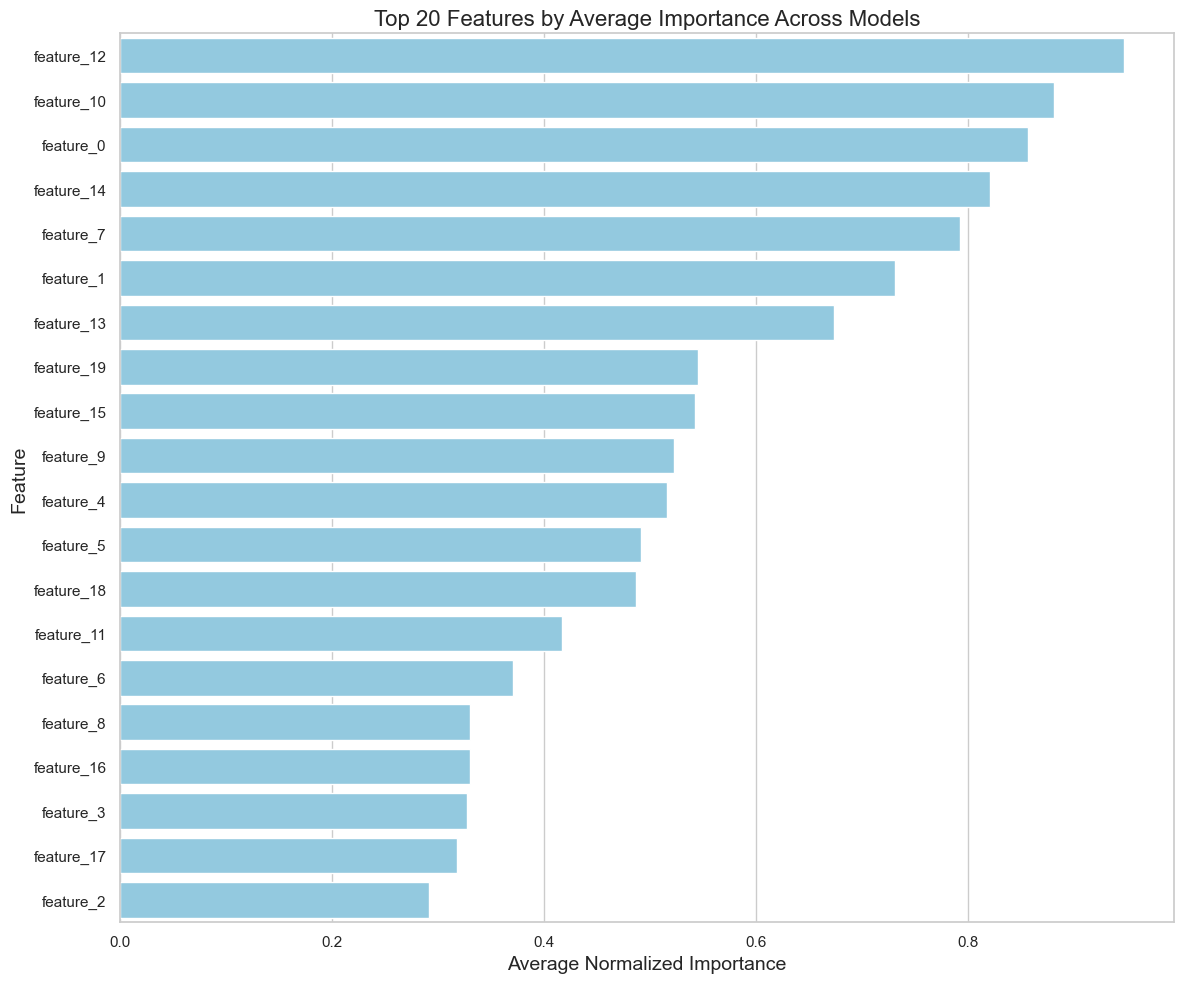

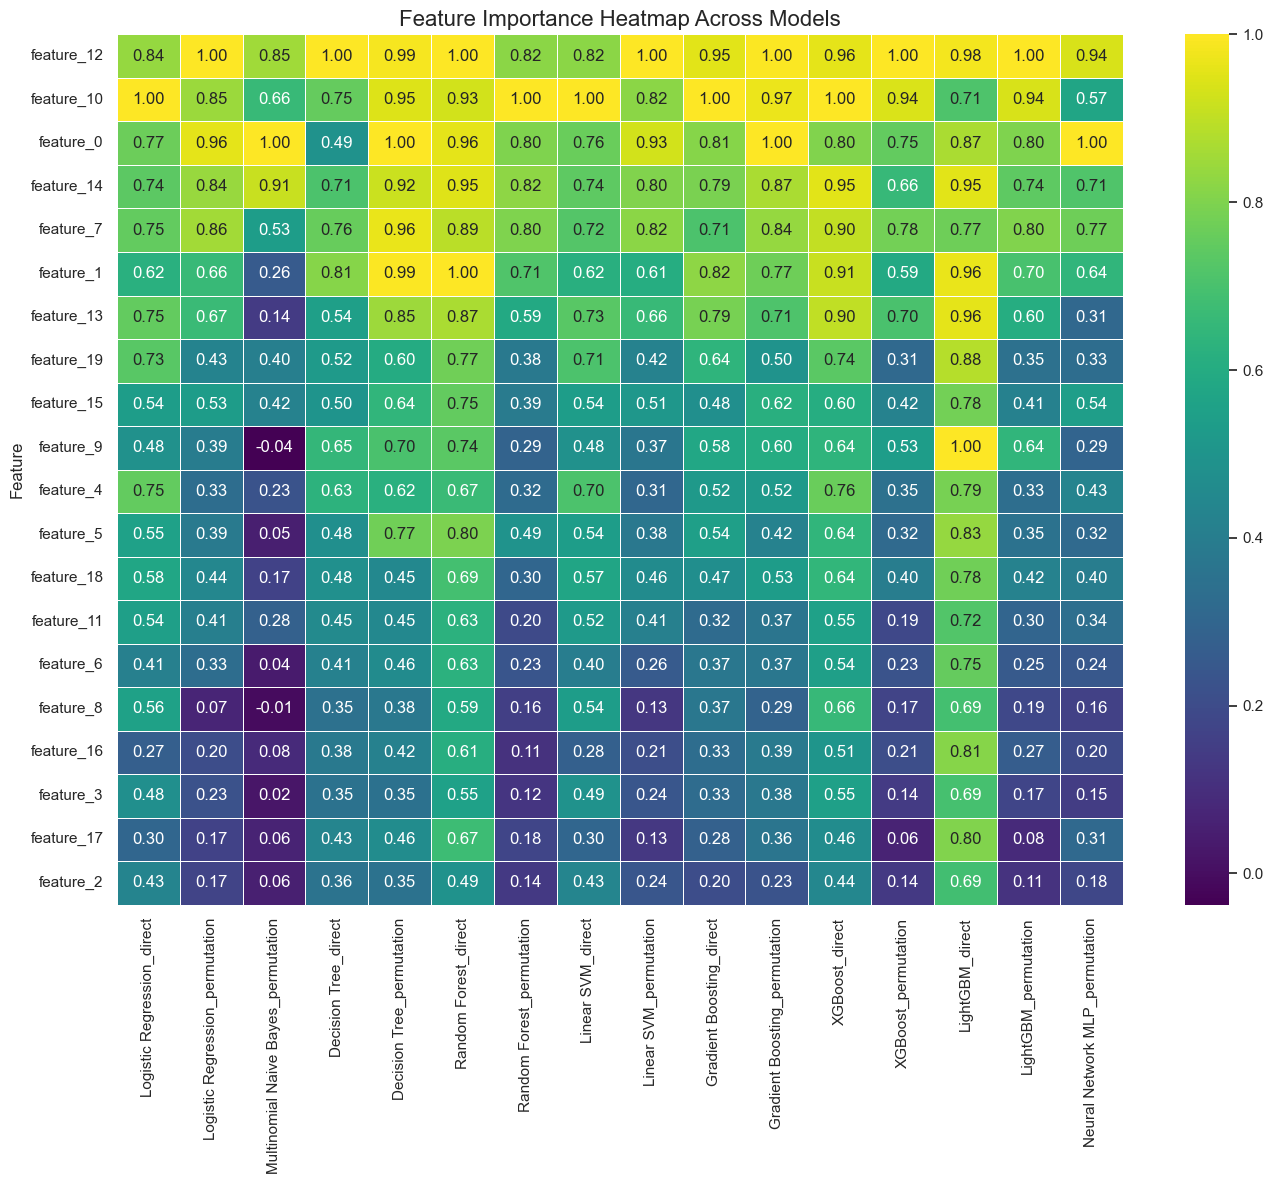

In [21]:
from feature_importance_analysis import analyze_feature_importance


try:
    # Analyze feature importance
    importance_results = analyze_feature_importance(
        evaluator, 
        X, 
        y, 
        feature_names=feature_names,
        top_n=20
    )
except Exception as e:
    print(f"Error analyzing feature importance: {e}")